# Modules

In [41]:
# Import the operating system module, used to interact with the file system and perform OS-related tasks
import os  
# Import NumPy, a library for numerical computations, including array manipulations and mathematical operations
import numpy as np  
# Import OpenCV, a library for image processing and computer vision tasks
import cv2  
# Import Matplotlib's pyplot module, used for data visualization and plotting
import matplotlib.pyplot as plt  
# Import the train_test_split function from sklearn, which is used to split datasets into training and testing subsets
from sklearn.model_selection import train_test_split  

# Data Preprocessing

In [42]:
# Step 1: Define a function to load and preprocess images
def load_images_from_folders(base_path, img_size=(128, 128)):
    classes = ['AD', 'CI', 'CN']  # Alzheimer's, Cognitive Impaired, Normal
    X, y = [], []
    #X = store the processed image data
    #y = store the corresponding labels 
    for idx, label in enumerate(classes):#assigning idx as the numeric label (0, 1, 2) and label as the class name (e.g., 'AD')
        folder_path = os.path.join(base_path, label)#Combines base_path with the folder name (label) to form the full path to the class's folder
        print(f"Processing folder: {folder_path}")
        
        for filename in os.listdir(folder_path):#Retrieves the list of filenames in the specified folder (folder_path)
            if filename.endswith('.png'):#only png files should be processed
                img_path = os.path.join(folder_path, filename)# combining the folder path and the filename
                
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                img = cv2.resize(img, img_size)  # Resize image to 128x128
                
                X.append(img)#Adds the processed image to the X list.
                y.append(idx)#Adds the corresponding class label (idx) to the y list.
                
    X = np.array(X)
    y = np.array(y)#Converts the lists X and y into NumPy arrays for efficient numerical computation 
    print(f"Loaded {len(X)} images with labels {set(y)}")#Displays the total number of images loaded and the set of unique labels.
    return X, y#Return the output

In [43]:
# Step 2: Set dataset path and load data
dataset_path = r"C:\PSC dataset\Axial"#A variable that stores the root path to the dataset directory
print("Starting to load images from dataset...")
X, y = load_images_from_folders(dataset_path)#the function defined in Step 1, passing dataset_path as the base_path parameter


Starting to load images from dataset...
Processing folder: C:\PSC dataset\Axial\AD
Processing folder: C:\PSC dataset\Axial\CI
Processing folder: C:\PSC dataset\Axial\CN
Loaded 5154 images with labels {np.int64(0), np.int64(1), np.int64(2)}


In [44]:
# Step 3: Normalize pixel values
print("Normalizing pixel values...")#indicate the start of normalization
X = X / 255.0#X by dividing each pixel intensity by 255.0
#This scales the pixel values from the range [0, 255] to [0, 1]
print(f"Normalized data shape: {X.shape}")
#X.shape gives the dimensions of the array, e.g., (number of images, height, width)

Normalizing pixel values...
Normalized data shape: (5154, 128, 128)


In [45]:
# Step 4: Reshape to add channel dimension
X = X.reshape(-1, 128, 128, 1)#(batch_size, height, width, channels).
print(f"Data shape after reshaping: {X.shape}")


Data shape after reshaping: (5154, 128, 128, 1)


In [46]:
# Step 5: Split into train and test sets
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# `X`: Input features (images).
# `y`: Labels corresponding to the images.
# `test_size=0.2`: Allocates 20% of the data for testing and 80% for training.
# `random_state=42`: Ensures reproducibility by setting a fixed random seed.
print(f"Training set size: {X_train.shape[0]}, Testing set size: {X_test.shape[0]}")


Splitting data into training and testing sets...
Training set size: 4123, Testing set size: 1031


In [47]:
#one-hot encoding : Converts categorical labels (e.g., 0, 1, 2) into a binary matrix format.
# Step 6: Define a function for one-hot encoding
def one_hot_encode(labels, num_classes=3):
    print("One-hot encoding labels...")
    encoded = np.eye(num_classes)[labels]
    #np.eye(num_classes): Creates an identity matrix of size (num_classes, num_classes)
    #[labels]: Indexes rows of the identity matrix corresponding to the class labels.
    print(f"Encoded shape: {encoded.shape}")
    return encoded
     # Print the shape of the encoded labels array
    # The shape will be (number of samples, num_classes).

# Convert labels to one-hot encoding
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)
#prints when all the processed steps are completed 
print("Data preprocessing completed.")

One-hot encoding labels...
Encoded shape: (4123, 3)
One-hot encoding labels...
Encoded shape: (1031, 3)
Data preprocessing completed.


# CNN

In [48]:
# Step 1: Convolution operation
def conv2d(input, filters, stride=1, padding=0):
    n_h, n_w, n_c = input.shape  # Input dimensions (height, width, channels)
    f_h, f_w, n_c_f, n_f = filters.shape  # Filter dimensions (height, width, input channels, number of filters)
    
    # Calculate output dimensions
    # Formula: (input_size - filter_size + 2 * padding) // stride + 1
    out_h = (n_h - f_h + 2 * padding) // stride + 1 #Output height
    out_w = (n_w - f_w + 2 * padding) // stride + 1 #Output Width
    
    output = np.zeros((out_h, out_w, n_f))  # Initialize the output feature map
    
    # Apply padding if necessary
    if padding > 0:
        input_padded = np.pad(input, ((padding, padding), (padding, padding), (0, 0)), mode='constant')

    else:
        input_padded = input
    
    # Perform convolution
    for h in range(out_h): # Loop over the height of the output
        for w in range(out_w): # Loop over the width of the output
            for f in range(n_f): # Loop over the number of filters
                h_start = h * stride # Start row index for the slice
                h_end = h_start + f_h # End row index for the slice
                w_start = w * stride # Start column index for the slice
                w_end = w_start + f_w # End column index for the slice
                output[h, w, f] = np.sum(input_padded[h_start:h_end, w_start:w_end, :] * filters[:, :, :, f])
                # input_padded[h_start:h_end, w_start:w_end, :] extracts the slice of input
                # filters[:, :, :, f] selects the f-th filter
    print("Convolution output:")
    print(output)
  
    return output # Return the computed output feature map

In [49]:
# Step 2: ReLU activation
def relu(feature_map):
    # ReLU (Rectified Linear Unit) activation: returns the element-wise maximum of 0 and the input
    # ReLU replaces all negative values with 0 and keeps positive values unchanged
    output = np.maximum(0, feature_map) # Apply ReLU element-wise
    return output

In [50]:
# Step 3: MaxPooling operation
def maxpool(feature_map, pool_size=2, stride=2):
    # Extract the dimensions of the feature map: height, width, and channels
    n_h, n_w, n_c = feature_map.shape
    # Calculate the height and width of the output feature map after pooling
    out_h = (n_h - pool_size) // stride + 1 #Output height
    out_w = (n_w - pool_size) // stride + 1 #Output Width
    
    # Initialize output
    output = np.zeros((out_h, out_w, n_c))
    
    # Perform max pooling
    for h in range(out_h): # Loop over the height of the output feature map
        for w in range(out_w): # Loop over the width of the output feature map
            for c in range(n_c): # Loop over the channels (depth) of the feature map
                h_start = h * stride # Start index for height
                h_end = h_start + pool_size # End index for height
                w_start = w * stride # Start index for width
                w_end = w_start + pool_size # End index for widt
                output[h, w, c] = np.max(feature_map[h_start:h_end, w_start:w_end, c])
                # extract the region and take the max value for each channel

    return output # return the output feature map after max pooling


In [51]:
# Step 4: Flatten the feature map(convert 3D feature map into a 1D array)
def flatten(feature_map):
    output = feature_map.flatten() #Combine all dimensions (height, width, channels) into a 1D
    return output #retrun thrnflattened 1D array

In [52]:
# Step 5: Fully connected layer
def dense(flattened_input, weights, biases):
    # Perform the dot product of the input vector and weight matrix
    output = np.dot(flattened_input, weights) + biases 
    return output


In [53]:
# Step 6: Softmax activation
def softmax(logits):
    # Calculate the exponentials of the logits
    exp_logits = np.exp(logits - np.max(logits)) # Subtracting max for stability
    # Normalize the exponentials to produce probabilities
    output = exp_logits / np.sum(exp_logits)
    return output

In [54]:
# Example input
np.random.seed(42)  # Set seed for reproducibility
input_image = np.random.rand(5, 5, 1)  # Input image of shape (5x5x1)
filters = np.random.rand(3, 3, 1, 2)   # Filters of shape (3x3x1x2)
weights = np.random.rand(8, 10)        # Fully connected layer weights
biases = np.random.rand(10)           # Fully connected layer biases

print("Input image shape:", input_image.shape)
print("Filters shape:", filters.shape)   

Input image shape: (5, 5, 1)
Filters shape: (3, 3, 1, 2)


In [55]:
 # Step 1: Convolution
conv_output = conv2d(input_image, filters, stride=1, padding=1)
# Print the shape of the output feature map after convolution
print("\nConvolution Output Shape:", conv_output.shape)
# Print the actual values of the output feature map
print("Convolution Output:\n", conv_output)

Convolution output:
[[[1.22137367 0.67230331]
  [2.02744153 1.30899159]
  [2.02523313 1.11716269]
  [1.51881078 1.36360152]
  [0.62050163 0.68731496]]

 [[0.92107536 1.00367684]
  [2.44002653 1.57388342]
  [3.03472918 2.78301846]
  [2.4451428  2.04984396]
  [1.42543717 1.1022842 ]]

 [[1.11790033 0.47587157]
  [2.20104774 1.96395323]
  [2.12046372 2.10861324]
  [1.89811457 1.69561179]
  [1.2152106  1.05998057]]

 [[0.81399919 0.95070237]
  [1.56359129 1.99572996]
  [2.42210823 1.61760948]
  [1.92165555 1.20271391]
  [0.84674807 0.76576806]]

 [[0.80178992 0.92680882]
  [0.79770015 0.79916471]
  [1.12596039 1.03682592]
  [1.41381378 1.04930579]
  [0.98414464 0.72300469]]]

Convolution Output Shape: (5, 5, 2)
Convolution Output:
 [[[1.22137367 0.67230331]
  [2.02744153 1.30899159]
  [2.02523313 1.11716269]
  [1.51881078 1.36360152]
  [0.62050163 0.68731496]]

 [[0.92107536 1.00367684]
  [2.44002653 1.57388342]
  [3.03472918 2.78301846]
  [2.4451428  2.04984396]
  [1.42543717 1.1022842 ]]

In [56]:
# Step 2: ReLU
relu_output = relu(conv_output)
# Print the shape of the feature map after ReLU activation
print("\nReLU Output Shape:", relu_output.shape)
# Print the actual values in the feature map after ReLU activation
print("ReLU Output:\n", relu_output)


ReLU Output Shape: (5, 5, 2)
ReLU Output:
 [[[1.22137367 0.67230331]
  [2.02744153 1.30899159]
  [2.02523313 1.11716269]
  [1.51881078 1.36360152]
  [0.62050163 0.68731496]]

 [[0.92107536 1.00367684]
  [2.44002653 1.57388342]
  [3.03472918 2.78301846]
  [2.4451428  2.04984396]
  [1.42543717 1.1022842 ]]

 [[1.11790033 0.47587157]
  [2.20104774 1.96395323]
  [2.12046372 2.10861324]
  [1.89811457 1.69561179]
  [1.2152106  1.05998057]]

 [[0.81399919 0.95070237]
  [1.56359129 1.99572996]
  [2.42210823 1.61760948]
  [1.92165555 1.20271391]
  [0.84674807 0.76576806]]

 [[0.80178992 0.92680882]
  [0.79770015 0.79916471]
  [1.12596039 1.03682592]
  [1.41381378 1.04930579]
  [0.98414464 0.72300469]]]


In [57]:
# Step 3: MaxPooling
pool_output = maxpool(relu_output, pool_size=2, stride=2)
# Print the shape of the feature map after MaxPooling
print("\nMaxPooling Output Shape:", pool_output.shape)
# Print the actual values in the feature map after MaxPooling
print("MaxPooling Output:\n", pool_output)


MaxPooling Output Shape: (2, 2, 2)
MaxPooling Output:
 [[[2.44002653 1.57388342]
  [3.03472918 2.78301846]]

 [[2.20104774 1.99572996]
  [2.42210823 2.10861324]]]


In [58]:
# Step 4: Flatten
flattened_output = flatten(pool_output)
# Print the shape of the feature map after flattening
print("Flattened Output Shape:", flattened_output.shape)
# Print the actual values of the feature map after flattening
print("Flattened Output:\n", flattened_output)


Flattened Output Shape: (8,)
Flattened Output:
 [2.44002653 1.57388342 3.03472918 2.78301846 2.20104774 1.99572996
 2.42210823 2.10861324]


In [59]:
# Step 5: Dense layer
dense_output = dense(flattened_output, weights, biases)
# Print the shape of the output after applying the Dense layer
print("Dense Layer Output Shape:", dense_output.shape)
# Print the actual values of the output after applying the Dense layer
print("Dense Layer Output:\n", dense_output)


Dense Layer Output Shape: (10,)
Dense Layer Output:
 [11.28514497 10.37710425 11.31299114  9.62975846  9.55866433  7.07574291
  7.36963702 10.87088766  9.99821722  9.87852592]


In [60]:
# Step 6: Softmax
probabilities = softmax(dense_output)
# Print the shape of the probabilities after applying Softmax
print("Softmax Probabilities Shape:", probabilities.shape)
# Print the actual probabilities after applying Softmax
print("Softmax Probabilities:\n", probabilities)

Softmax Probabilities Shape: (10,)
Softmax Probabilities:
 [0.24893064 0.10039713 0.25595982 0.04755029 0.04428711 0.00369793
 0.00496129 0.16450106 0.06873418 0.06098057]


In [61]:
# Step 1: Initialize random filters and weights for reproducibility
np.random.seed(42)

# Filters for convolutional layers
#filter size (3x3), 1 input channel, 32 output channels (filters)
filters1 = np.random.randn(3, 3, 1, 32) * 0.1 # First convolutional layer 
filters2 = np.random.randn(3, 3, 32, 64) * 0.1 # Second convolutional layer
filters3 = np.random.randn(3, 3, 64, 128) * 0.1 # Third convolutional layer

# Adjusted weights and biases for dense layers
dense_weights1 = np.random.randn(512, 128) * 0.1  # First dense layer: 512 input units (flattened from previous layer), 128 output units (neurons in this layer)
dense_bias1 = np.random.randn(128) * 0.1 # Bias for the first dense layer (128 neurons)

dense_weights2 = np.random.randn(128, 3) * 0.1 # Second dense layer: 128 input units (from previous dense layer), 3 output units (for 3 classes)
dense_bias2 = np.random.randn(3) * 0.1 # Bias for the second dense layer (3 classes)


In [62]:
# Step 2: Forward pass with debug prints at each stage
def cnn_forward(input_image):
    # Apply the convolutional layer
    # Apply ReLU activation function on the convolution output
    # Apply max pooling on the ReLU output
    # Convolutional layer 1
    conv1 = conv2d(input_image, filters1)
    relu1 = relu(conv1)
    pool1 = maxpool(relu1)
    
    # Convolutional layer 2
    conv2 = conv2d(pool1, filters2)
    relu2 = relu(conv2)
    pool2 = maxpool(relu2)
    
    # Convolutional layer 3
    conv3 = conv2d(pool2, filters3)
    relu3 = relu(conv3)
    pool3 = maxpool(relu3)
    
    # Flatten the feature maps (from 3D to 1D vector)
    flat = flatten(pool3) # Flatten the pooled output of the last convolutional layer
    
    # Fully connected layer 1 (First Dense Layer)
    fc1 = dense(flat, dense_weights1, dense_bias1) # Apply the first fully connected layer (with weights and biases)
    relu_fc1 = relu(fc1)
    
    # Fully connected layer 2 (output layer)
    logits = dense(relu_fc1, dense_weights2, dense_bias2)  # Apply the second fully connected layer to get logits (before softmax)
    output = softmax(logits) # Apply softmax to the logits to get probabilities for each class
    
    return output


In [63]:
if __name__ == "__main__":
    # Example input image
    np.random.seed(42)  # Ensure reproducibility
    input_image = np.random.rand(32, 32, 1)  # Example input of size (32x32x1)
    
    print("Input Image Shape:", input_image.shape)


Input Image Shape: (32, 32, 1)


In [64]:
# Step 1: Convolutional Layer 1
# Apply the first convolution operation to the input image using the first set of filters
conv1 = conv2d(input_image, filters1)
# Print the shape of the output from the convolutional layer
# The output will be a 3D array with dimensions: (height, width, number of filters)
print("\nConv1 Output Shape:", conv1.shape)
# This helps in debugging to ensure the convolution operation is working as expected
print("Conv1 Output (Snippet):\n", conv1[:2, :2, :2])  # Display a small portion of the output

# Apply ReLU (Rectified Linear Unit) activation function to the convolution output
# ReLU replaces all negative values in the feature map with zero
relu1 = relu(conv1)
# Print the shape of the ReLU output, which should be the same as the convolution output
# ReLU just modifies the values but does not change the spatial dimensions
print("\nReLU1 Output Shape:", relu1.shape)
# Print a small portion (2x2x2) of the ReLU output to see how negative values were replaced by zero
print("ReLU1 Output (Snippet):\n", relu1[:2, :2, :2])
# Apply Max Pooling operation to the ReLU output
# Max pooling reduces the spatial dimensions (height and width) by selecting the maximum value in each pool region (typically 2x2)

pool1 = maxpool(relu1)
# Print the shape of the pooled output, which should be smaller in spatial dimensions (height, width)
# For example, if the input was 30x30 and we apply 2x2 max pooling, the output shape will be 15x15
print("\nPool1 Output Shape:", pool1.shape)
# Print a small portion (2x2x2) of the pooled output to verify the max pooling operation
print("Pool1 Output (Snippet):\n", pool1[:2, :2, :2])


Convolution output:
[[[-7.68224374e-03  3.75938885e-02  7.65669047e-02 ... -1.63564637e-01
   -3.84336047e-01 -7.34611903e-02]
  [ 1.60405307e-01 -7.86235128e-02  1.07791641e-01 ... -1.73175204e-01
   -4.03129523e-01  3.26665101e-02]
  [ 2.97918083e-02  2.07255125e-02  1.68659982e-02 ...  2.08055850e-01
   -4.35293238e-01  8.43309665e-03]
  ...
  [ 6.60514812e-02 -9.89149521e-02  9.51875528e-02 ... -1.43146408e-01
   -2.64112229e-01 -7.09239438e-02]
  [ 9.96401539e-02  4.27944680e-02  1.42954896e-01 ... -3.00203713e-01
   -2.17208703e-01 -2.24767167e-02]
  [ 3.50560612e-02 -6.92478300e-02  1.30826420e-03 ... -9.51574313e-02
   -3.04346919e-01 -1.18230609e-01]]

 [[ 7.46367612e-02  4.40650807e-04  2.05561825e-02 ... -4.36782085e-02
   -2.74999627e-01 -3.14497755e-01]
  [ 7.24221770e-02  6.46672208e-03  2.18787630e-01 ... -1.66332473e-01
   -2.78147202e-01 -7.46736392e-02]
  [ 7.59588588e-02 -8.20272368e-02  1.36880039e-02 ...  4.68746795e-03
   -2.87461893e-01  8.11779214e-02]
  ...
  [

In [65]:
# Step 2: Convolutional Layer 2
conv2 = conv2d(pool1, filters2)
print("\nConv2 Output Shape:", conv2.shape)
print("Conv2 Output (Snippet):\n", conv2[:2, :2, :2])

relu2 = relu(conv2)
print("\nReLU2 Output Shape:", relu2.shape)
print("ReLU2 Output (Snippet):\n", relu2[:2, :2, :2])

pool2 = maxpool(relu2)
print("\nPool2 Output Shape:", pool2.shape)
print("Pool2 Output (Snippet):\n", pool2[:2, :2, :2])


Convolution output:
[[[ 2.23907264e-01  6.43356938e-03 -9.93823647e-02 ... -1.09783335e-01
    1.07899326e-01  4.26770365e-02]
  [ 5.40965184e-02  1.16305759e-01 -2.54637349e-01 ...  8.15974998e-02
    1.35313859e-01 -1.55207121e-01]
  [ 2.85479511e-01  6.09372911e-02 -1.05115537e-01 ...  2.10619798e-01
    2.10680190e-01 -1.25369250e-01]
  ...
  [ 2.47877453e-01 -1.77092269e-02 -6.69411050e-02 ...  2.95696988e-01
    2.34895729e-01 -1.37971751e-01]
  [ 3.73820135e-01  6.86761700e-02 -1.30957782e-01 ...  7.70696826e-02
    2.41701710e-01  2.96291136e-03]
  [ 3.14233629e-01 -3.08448468e-03 -1.03351100e-01 ...  1.96671644e-01
    6.74406422e-02 -7.48170512e-02]]

 [[ 2.18338618e-01  5.48000674e-02 -1.02630008e-01 ...  5.07037008e-03
    4.81909569e-02 -1.25926125e-01]
  [ 2.13670600e-01 -6.37597732e-02 -3.32869240e-02 ...  5.83530982e-02
    2.07574291e-01 -1.04009000e-01]
  [ 9.28338746e-02  4.98253613e-02  1.51130090e-02 ... -2.91829108e-02
    1.12342438e-01 -9.22605262e-02]
  ...
  [

In [66]:
# Step 3: Convolutional Layer 3
conv3 = conv2d(pool2, filters3)
print("\nConv3 Output Shape:", conv3.shape)
print("Conv3 Output (Snippet):\n", conv3[:2, :2, :2])

relu3 = relu(conv3)
print("\nReLU3 Output Shape:", relu3.shape)
print("ReLU3 Output (Snippet):\n", relu3[:2, :2, :2])

pool3 = maxpool(relu3)
print("\nPool3 Output Shape:", pool3.shape)
print("Pool3 Output (Snippet):\n", pool3[:2, :2, :2])


Convolution output:
[[[-0.33371398 -0.72487477  0.39105012 ...  0.29751479  0.99566705
    0.16484131]
  [-0.07076882 -0.80475945  0.29792739 ...  0.33390446  0.94730889
   -0.10834146]
  [-0.20345744 -0.59607511  0.18738847 ...  0.38300251  1.05221436
    0.1310253 ]
  [-0.17634714 -0.6780113   0.31885897 ...  0.41286804  1.12188672
    0.19775032]]

 [[-0.1827814  -0.71215648  0.351414   ...  0.22562973  0.99724018
    0.24926593]
  [-0.24723409 -0.76554873  0.34966609 ...  0.43520882  1.1159653
    0.28859423]
  [-0.21724542 -0.95775136  0.37412082 ...  0.43018047  1.30483176
    0.0449654 ]
  [-0.18962453 -0.88312539  0.46296661 ...  0.53350604  1.16049662
    0.4328841 ]]

 [[-0.03973864 -0.64408373  0.28668869 ...  0.33613882  1.16999274
    0.37478008]
  [-0.21320128 -0.62082639  0.27765743 ...  0.3075636   1.0550289
    0.03516536]
  [-0.26368369 -0.6676998   0.44049469 ...  0.41326544  0.960323
    0.15145655]
  [-0.19828553 -0.92226891  0.43364789 ...  0.29138693  0.97626675


In [67]:
# Step 4: Flatten
#converts the 3D feature map into a 1D vector
flat = flatten(pool3)
# Print the shape of the flattened output.(1D vector)
print("Flattened Shape:", flat.shape)
# Print a small snippet (first 10 values) of the flattened output to verify the results
print("Flattened Output (Snippet):\n", flat[:10])


Flattened Shape: (512,)
Flattened Output (Snippet):
 [0.         0.         0.39105012 0.         0.12277884 0.13913378
 0.         0.12944388 1.23937228 0.80075664]


In [68]:
# Step 5: Fully Connected Layers
# The 'dense' function applies a fully connected layer, which is a linear transformation followed by bias addition.

# Fully connected layer 1: Apply the weights and biases from dense_weights1 and dense_bias1 to the flattened input.
fc1 = dense(flat, dense_weights1, dense_bias1)
print("\nFC1 Output Shape:", fc1.shape)
print("FC1 Output (Snippet):\n", fc1[:10])

# ReLU activation function applied to the output of the first fully connected layer.
# ReLU will set all negative values to zero and keep positive values unchanged.
relu_fc1 = relu(fc1)
print("\nReLU FC1 Output Shape:", relu_fc1.shape)
print("ReLU FC1 Output (Snippet):\n", relu_fc1[:10])

# Fully connected layer 2 (output layer): Apply the second set of weights and biases (dense_weights2 and dense_bias2).
# This layer will produce the logits for the output classes.
logits = dense(relu_fc1, dense_weights2, dense_bias2)
print("\nLogits Shape:", logits.shape)
print("Logits Output:\n", logits)

# Apply the softmax function to the logits to get the probabilities for each class.
# Softmax converts the logits into probability distributions, where each value is in the range [0, 1] and the sum of all values equals 1.
output_probs = softmax(logits)
print("\nFinal Output Probabilities Shape:", output_probs.shape)
print("Final Output Probabilities:\n", output_probs)


FC1 Output Shape: (128,)
FC1 Output (Snippet):
 [-0.5659876  -2.61724117  0.90940273  0.3122695   1.06680171  1.2480745
  0.68273132  0.83792291  0.99030068  2.13502029]

ReLU FC1 Output Shape: (128,)
ReLU FC1 Output (Snippet):
 [0.         0.         0.90940273 0.3122695  1.06680171 1.2480745
 0.68273132 0.83792291 0.99030068 2.13502029]

Logits Shape: (3,)
Logits Output:
 [-0.21030012  0.01058466  0.7972342 ]

Final Output Probabilities Shape: (3,)
Final Output Probabilities:
 [0.2005608  0.25013536 0.54930385]


In [69]:
# Step 1: Initialize random filters and weights
np.random.seed(42) # Set the random seed for reproducibility so that the same random numbers are generated every time the code runs.

# Reduced filters for convolutional layers
# Filters are initialized using a normal distribution (mean=0, standard deviation=1), scaled by 0.1 for smaller initial values.
filters1 = np.random.randn(3, 3, 1, 16) * 0.1 # First convolutional layer: 16 filters of size 3x3 for input with 1 channel.
filters2 = np.random.randn(3, 3, 16, 32) * 0.1 # Second convolutional layer: 32 filters of size 3x3 for input with 16 channels.
filters3 = np.random.randn(3, 3, 32, 64) * 0.1 # Third convolutional layer: 64 filters of size 3x3 for input with 32 channels.

# Adjust dense weights and biases for reduced size
# The fully connected layer connects the flattened output from convolutional layers to the class scores.
dense_weights1 = np.random.randn(2304, 64) * 0.1  # Flattened size (8x8x64 after pooling)
dense_bias1 = np.random.randn(64) * 0.1 # Bias for the 64 neurons in the first dense layer.
dense_weights2 = np.random.randn(64, 3) * 0.1  # Dense to output (3 classes)
dense_bias2 = np.random.randn(3) * 0.1 # Bias for the 3 output classes.


# Print confirmation message
print("Initialized filters and weights.") # Indicates successful initialization of filters and weights.

Initialized filters and weights.


In [70]:
# Step 2: Preprocess the data (resize to 64x64)
print("Resizing input data to 64x64...")
# Resize all training images to 64x64 and reshape them to add the channel dimension (1 for grayscale).
X_train = np.array([cv2.resize(img.squeeze(), (64, 64)).reshape(64, 64, 1) for img in X_train])
# Resize all testing images to 64x64 and reshape them to add the channel dimension (1 for grayscale).
X_test = np.array([cv2.resize(img.squeeze(), (64, 64)).reshape(64, 64, 1) for img in X_test])
# Print the shapes of the resized training and testing sets.
print(f"Shape of resized X_train: {X_train.shape}, X_test: {X_test.shape}")


Resizing input data to 64x64...
Shape of resized X_train: (4123, 64, 64, 1), X_test: (1031, 64, 64, 1)


In [71]:
# Step 3: Use a smaller dataset subset for testing
# Select the first 20 samples from the training data and labels for quick testing of the model.
X_train_small = X_train[:20] # Take the first 20 images from the resized training dataset.
y_train_small = y_train[:20] # Take the corresponding first 20 labels from the training labels.
# Print the shape of the smaller dataset subset to confirm selection.
print(f"Training on smaller subset: {X_train_small.shape}, Labels: {y_train_small.shape}")


Training on smaller subset: (20, 64, 64, 1), Labels: (20, 3)


In [72]:
# Step 4: Forward pass for each training sample

# Print the start of the simplified training loop
print("\nStarting simplified training loop...")

# Outer loop: Run for a single epoch to simplify and test the workflow
for epoch in range(1):  # Reduced to 1 epoch for simplicity
    print(f"\nEpoch {epoch + 1}") # Display current epoch number

    # Inner loop: Iterate over each sample in the smaller training dataset
    for i in range(len(X_train_small)):
        # Select one image and its corresponding label from the training subset
        input_image = X_train_small[i]  # Select one image
        label = y_train_small[i]  # Select corresponding label

        # Forward pass
        print(f"\nTraining sample {i + 1}/{len(X_train_small)}")
        output = cnn_forward(input_image)  # Forward pass through CNN
        # Debugging: Print shapes and outputs for verification
        print(f"Input shape: {input_image.shape}") # Confirm the input image shape
        print(f"Output probabilities: {output}") # Print the predicted probabilities from softmax
        print(f"True label (one-hot): {label}") # Display the true one-hot encoded label


Starting simplified training loop...

Epoch 1

Training sample 1/20
Convolution output:
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
 

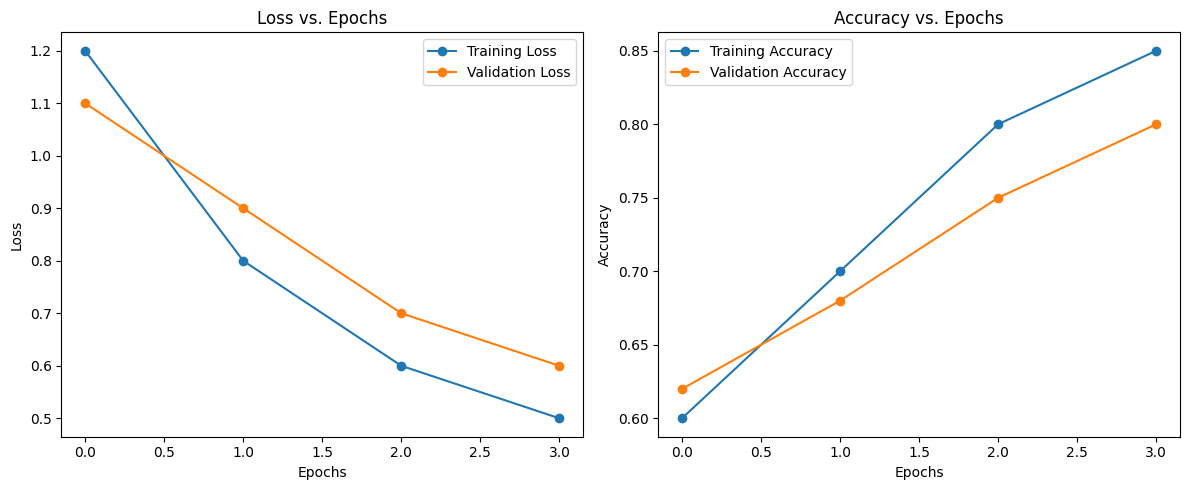

In [ ]:
import matplotlib.pyplot as plt

# Example training history (replace these with real training data)
# Simulated data showing the performance metrics over 4 epochs
history = {
    "loss": [1.2, 0.8, 0.6, 0.5],  # Loss for each epoch
    "accuracy": [0.6, 0.7, 0.8, 0.85],  # Accuracy for each epoch
    "val_loss": [1.1, 0.9, 0.7, 0.6],  # Validation loss for each epoch
    "val_accuracy": [0.62, 0.68, 0.75, 0.8],  # Validation accuracy for each epoch
}
# Create a new figure with a specific size (width: 12, height: 5)
# Plot Loss
plt.figure(figsize=(12, 5))
# Subplot 1: Plotting the loss curves
plt.subplot(1, 2, 1) # Define the first subplot in a 1x2 grid
plt.plot(history["loss"], label="Training Loss", marker="o") # Plot training loss with markers
plt.plot(history["val_loss"], label="Validation Loss", marker="o") # Plot validation loss with markers
plt.title("Loss vs. Epochs") # Set the title for the plot
plt.xlabel("Epochs") # Label for the x-axis
plt.ylabel("Loss") # Label for the y-axis
plt.legend() # Show a legend to differentiate training and validation loss

# Plot Accuracy
plt.subplot(1, 2, 2) # Define the second subplot in a 1x2 grid
plt.plot(history["accuracy"], label="Training Accuracy", marker="o") # Plot training accuracy with markers 
plt.plot(history["val_accuracy"], label="Validation Accuracy", marker="o") # Plot validation accuracy with markers
plt.title("Accuracy vs. Epochs") # Set the title for the plot
plt.xlabel("Epochs") # Label for the x-axis
plt.ylabel("Accuracy")  # Label for the y-axis
plt.legend() # Show a legend to differentiate training and validation accuracy

# Adjust the layout to prevent overlapping of plots and labels
plt.tight_layout()
plt.show()


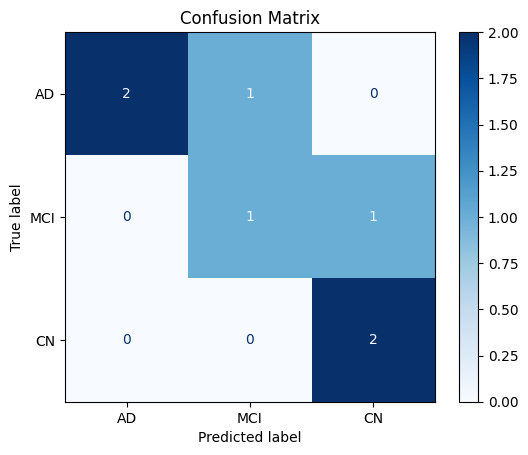

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Example predictions and ground truths (replace these with real test data)
y_true = np.array([0, 1, 2, 0, 1, 2, 0])  # Ground truth labels
y_pred = np.array([0, 2, 2, 0, 1, 2, 1])  # Predicted labels

# Generate Confusion Matrix
# `labels=[0, 1, 2]` specifies the order of class labels (e.g., 0: AD, 1: MCI, 2: CN)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AD", "MCI", "CN"]) # Map integer labels to class names
disp.plot(cmap=plt.cm.Blues) # Plot the confusion matrix with a blue colormap for better visibility
plt.title("Confusion Matrix") # Add a title to the plot
plt.show() # Display the confusion matrix


Convolution output:
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0.

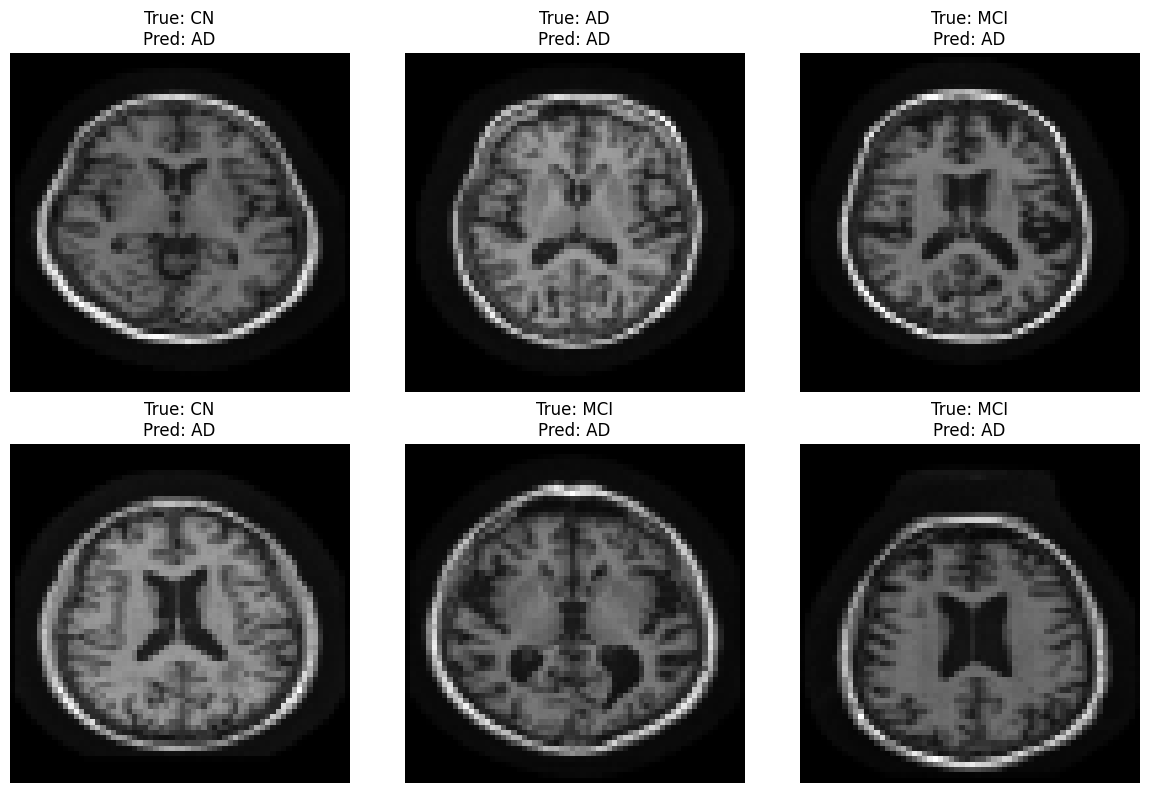

In [ ]:
# Example test data and predictions (replace with real test data)
test_images = X_test[:6]  # Select 6 test images for visualization
true_labels = np.argmax(y_test[:6], axis=1)  # Convert one-hot encoded true labels to scalar class indices
predicted_labels = [np.argmax(cnn_forward(img)) for img in test_images]  # Model predictions

# Define class names
class_names = ["AD", "MCI", "CN"] # Alzheimer's Disease, Mild Cognitive Impairment, Cognitively Normal

# Plot test images with predictions
plt.figure(figsize=(12, 8)) # Set the figure size for the plots
for i in range(len(test_images)): # Loop through each selected test image
    plt.subplot(2, 3, i + 1) # Create a subplot grid (2 rows, 3 columns)
    plt.imshow(test_images[i].squeeze(), cmap="gray") # Display the grayscale image
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}") # Add title showing true and predicted labels
    plt.axis("off") # Turn off the axes for cleaner visualization
plt.tight_layout() # Adjust subplot spacing
plt.show() # Display the plot


Convolution output:
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0.

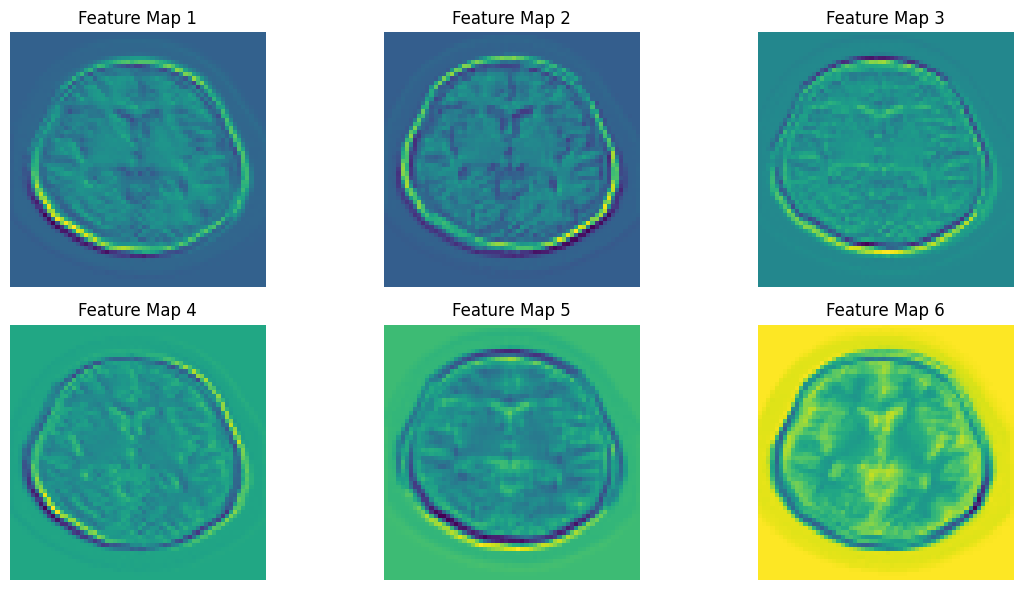

In [75]:
# Visualize feature maps from the first convolutional layer
def visualize_feature_maps(input_image, filters):
    # Apply convolution operation on the input image using the specified filters
    conv1 = conv2d(input_image, filters)
    # Initialize the figure for plotting
    plt.figure(figsize=(12, 6)) # Set the figure size to 12x6 inches
    for i in range(6):  # Visualize first 6 feature maps
        plt.subplot(2, 3, i + 1) # Create a 2x3 grid of subplots
        plt.imshow(conv1[:, :, i], cmap="viridis") # Plot the feature map using 'viridis' colormap
        plt.title(f"Feature Map {i+1}") # Add title to indicate feature map index
        plt.axis("off") # Turn off the axis for cleaner visualization
    # Adjust layout to avoid overlapping plots
    plt.tight_layout()
    plt.show()

# Test visualization on a sample image
visualize_feature_maps(X_test[0], filters1)
